# Model Training

## 1.1 Import Data and Required Packages
Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import joblib
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
import warnings

## Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/outlier_removed_organics.csv')

## Show Top 5 Records

In [3]:
df.head()

,Gender,Geographic Region,Loyalty Status,Neighborhood Cluster-7 Level,Affluence Grade,Age,Loyalty Card Tenure,ORGANICS
0,F,Midlands,Silver,D,5.0,70.0,8.0,1.0
1,M,Midlands,Tin,F,10.0,65.0,7.0,1.0
2,F,Midlands,Tin,A,11.0,68.0,8.0,0.0
3,F,Midlands,Tin,A,11.0,74.0,8.0,0.0
4,M,North,Tin,D,13.0,62.0,5.0,0.0


## Preparing X and Y variables

In [4]:
X = df.drop(columns=['ORGANICS'],axis=1)

In [5]:
X.head()

,Gender,Geographic Region,Loyalty Status,Neighborhood Cluster-7 Level,Affluence Grade,Age,Loyalty Card Tenure
0,F,Midlands,Silver,D,5.0,70.0,8.0
1,M,Midlands,Tin,F,10.0,65.0,7.0
2,F,Midlands,Tin,A,11.0,68.0,8.0
3,F,Midlands,Tin,A,11.0,74.0,8.0
4,M,North,Tin,D,13.0,62.0,5.0


In [6]:
def print_unique_categories(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = df[column].unique()
            print(f"Unique values for '{column}': {unique_values}")

In [7]:
print_unique_categories(df)

Unique values for 'Gender': ['F' 'M']
Unique values for 'Geographic Region': ['Midlands' 'North' 'South East' 'South West' 'Scottish']
Unique values for 'Loyalty Status': ['Silver' 'Tin' 'Gold' 'Platinum']
Unique values for 'Neighborhood Cluster-7 Level': ['D' 'F' 'A' 'C' 'B' 'E' 'U']


In [8]:
y=df['ORGANICS']

In [9]:
y.head()

0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: ORGANICS, dtype: float64

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
# Define the preprocessor
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [12]:
# Create a dictionary of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced'),
    'XGBClassifier': XGBClassifier(),
    'CatBoosting Classifier': CatBoostClassifier(verbose=False),
    'AdaBoost Classifier': AdaBoostClassifier()
}

# Create a dictionary to store pipeline models
pipelines = {}

# Create and store pipelines for each classifier
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

# Display the created pipelines
print(pipelines)

{'Logistic Regression': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  Index(['Gender', 'Geographic Region', 'Loyalty Status',
       'Neighborhood Cluster-7 Level'],
      dtype='object')),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  Index(['Affluence Grade', 'Age', 'Loyalty Card Tenure'], dtype='object'))])),
                ('classifier', LogisticRegression(class_weight='balanced'))]), 'K-Neighbors Classifier': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  Index(['Gender', 'Geographic Region', 'Loyalty Status

In [13]:
# Define hyperparameters for each classifier
param_grid = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'classifier__penalty': ['l1', 'l2']
    },
    'K-Neighbors Classifier': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'Decision Tree Classifier': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Random Forest Classifier': {
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'XGBClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'CatBoosting Classifier': {
        'classifier__iterations': [50, 100, 200],
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'AdaBoost Classifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
}

In [14]:
# Create a dictionary to store the best models after hyperparameter tuning
best_models = {}

# Perform hyperparameter tuning for each classifier
for name, pipeline in pipelines.items():
    print(f"Hyperparameter tuning for {name}")
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='f1', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store the best model
    best_models[name] = grid_search.best_estimator_
    
    # Print the best hyperparameters
    print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Best F1 score for {name}: {grid_search.best_score_}")
    print('=' * 35)



Hyperparameter tuning for Logistic Regression
Fitting 5 folds for each of 14 candidates, totalling 70 fits


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fi

Best hyperparameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best F1 score for Logistic Regression: 0.5985332831094371
Hyperparameter tuning for K-Neighbors Classifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters for K-Neighbors Classifier: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best F1 score for K-Neighbors Classifier: 0.5116825040452943
Hyperparameter tuning for Decision Tree Classifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for Decision Tree Classifier: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best F1 score for Decision Tree Classifier: 0.5851188240170915
Hyperparameter tuning for Random Forest Classifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters for Random Forest Classifier: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'c

In [15]:
# Find the model with the best F1 score
best_model_name = max(best_models, key=lambda k: grid_search.best_score_)
best_model = best_models[best_model_name]

# Save the best model using joblib or pickle
model_filename = "best_model.joblib"
joblib.dump(best_model, model_filename)
print(f'The best model ({best_model_name}) has been saved as {model_filename}')

The best model (Logistic Regression) has been saved as best_model.joblib


In [16]:
# Load the best model
best_model = joblib.load("best_model.joblib")

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print('Model performance for Test set:')
print("- Accuracy: {:.4f}".format(accuracy_test))
print("- Precision: {:.4f}".format(precision_test))
print("- Recall: {:.4f}".format(recall_test))
print("- F1 Score: {:.4f}".format(f1_test))

Model performance for Test set:
- Accuracy: 0.7213
- Precision: 0.5274
- Recall: 0.7158
- F1 Score: 0.6074


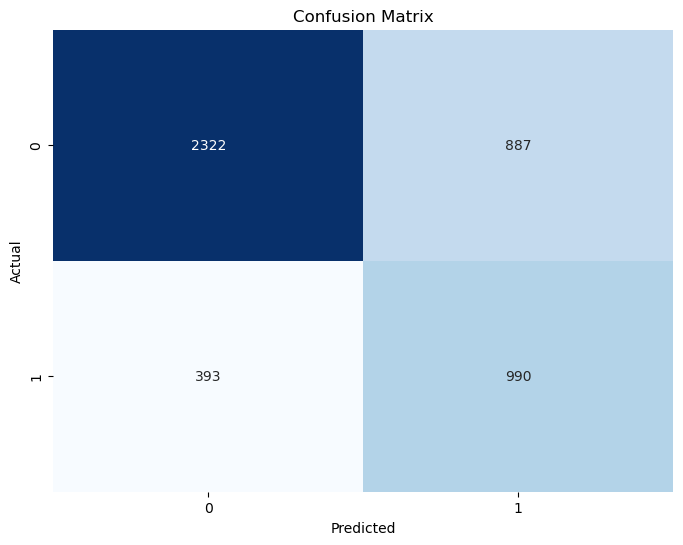

In [17]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Match': (y_test == y_test_pred)})
pred_df

,Actual Value,Predicted Value,Match
14284,0.0,1.0,False
14849,0.0,0.0,True
10483,0.0,1.0,False
13100,1.0,1.0,True
6053,0.0,0.0,True
...,...,...,...
10875,0.0,0.0,True
8049,0.0,0.0,True
1161,0.0,0.0,True
14377,1.0,1.0,True
